In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
n = 10
train_x = np.random.normal(size=(10000, n))
val_x = np.random.normal(size=(1000, n))
test_x = np.random.normal(size=(1000, n))

train_x = train_x.astype(np.float32)
val_x = val_x.astype(np.float32)
test_x = test_x.astype(np.float32)

mults = np.arange(n) + 1

train_y = np.random.normal(size=(train_x.shape[0], 1)) + np.expand_dims(np.sum(train_x * mults, axis=1) + 5, 1)
val_y = np.random.normal(size=(val_x.shape[0], 1)) + np.expand_dims(np.sum(val_x * mults, axis=1) + 5, 1)
test_y = np.random.normal(size=(test_x.shape[0], 1)) + np.expand_dims(np.sum(test_x * mults, axis=1) + 5, 1)

train_y = train_y.astype(np.float32)
val_y = val_y.astype(np.float32)
test_y = test_y.astype(np.float32)

In [3]:
print train_y.shape
train_y

(10000, 1)


array([[  1.21842957],
       [-21.6566906 ],
       [ 20.77809715],
       ..., 
       [-10.48579788],
       [-17.44668961],
       [ 21.74399948]], dtype=float32)

In [4]:
def rmse(predictions, actual):
    sse = np.sum(np.square(predictions - actual))
    return np.sqrt(sse / float(actual.shape[0]))

In [63]:
def loss_x_entropy(output, target):
    """Cross entropy loss
    See https://en.wikipedia.org/wiki/Cross_entropy
    Args:
        output: tensor of net output
        target: tensor of net we are trying to reconstruct
    Returns:
        Scalar tensor of cross entropy
    """
    with tf.name_scope("xentropy_loss"):
        net_output_tf = output
        target_tf = target
        cross_entropy = tf.add(tf.mul(tf.log(net_output_tf, name='log_output'), target_tf), 
                               tf.mul(tf.log(1 - net_output_tf), (1 - target_tf)))
        return -1 * tf.reduce_mean(tf.reduce_sum(cross_entropy, 1), name='xentropy_mean')

In [5]:
batch_size = 64
num_labels = train_y.shape[1]

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, n))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(val_x)
    tf_test_dataset = tf.constant(test_x)
    tf_tr_dataset = tf.constant(train_x)
  
    # Variables.
    weights = tf.Variable(tf.truncated_normal([n, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    loss = tf.nn.l2_loss(logits - tf_train_labels)
  
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(0.005).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # train_prediction = tf.nn.softmax(logits)
    train_prediction = logits
    valid_prediction = tf.matmul(tf_valid_dataset, weights) + biases
    test_prediction = tf.matmul(tf_test_dataset, weights) + biases
    tr_preds = tf.matmul(tf_tr_dataset, weights) + biases
    
num_steps = 20001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_x[offset:(offset + batch_size), :]
        batch_labels = train_y[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch RMSE: %.5f" % rmse(predictions, batch_labels))
            print("Validation RMSE: %.5f" % rmse(valid_prediction.eval(), val_y))
        
    print("Test RMSE: %.5f" % rmse(test_prediction.eval(), test_y))
    print("")
    print weights.eval()
    print biases.eval()
    print("")
    preds = tr_preds.eval()

Initialized
Minibatch loss at step 0: 11803.550781
Minibatch RMSE: 19.20575
Validation RMSE: 21.95086
Minibatch loss at step 500: 5462.754395
Minibatch RMSE: 13.06564
Validation RMSE: 15.87458
Minibatch loss at step 1000: 3368.707031
Minibatch RMSE: 10.26022
Validation RMSE: 11.11180
Minibatch loss at step 1500: 2184.039307
Minibatch RMSE: 8.26143
Validation RMSE: 7.45822
Minibatch loss at step 2000: 712.597900
Minibatch RMSE: 4.71897
Validation RMSE: 4.75868
Minibatch loss at step 2500: 218.062439
Minibatch RMSE: 2.61045
Validation RMSE: 2.87180
Minibatch loss at step 3000: 80.940277
Minibatch RMSE: 1.59040
Validation RMSE: 1.71456
Minibatch loss at step 3500: 46.013916
Minibatch RMSE: 1.19914
Validation RMSE: 1.18020
Minibatch loss at step 4000: 30.938417
Minibatch RMSE: 0.98327
Validation RMSE: 1.03172
Minibatch loss at step 4500: 26.239969
Minibatch RMSE: 0.90554
Validation RMSE: 1.00774
Minibatch loss at step 5000: 41.774998
Minibatch RMSE: 1.14257
Validation RMSE: 1.00429
Minibat

         actual       pred
0      1.218430   1.696934
1    -21.656691 -20.954771
2     20.778097  18.643614
3     14.115389  14.295713
4     15.549591  15.703230
5     -5.956771  -6.211721
6     -5.636234  -4.656400
7     -2.229832  -2.050319
8     15.249873  14.384365
9    -15.060951 -13.812401
10    16.838667  15.123272
11    28.378885  28.581181
12    25.921165  23.835848
13    16.532244  15.444082
14    29.890085  30.334002
15    30.920593  32.328770
16    39.543926  39.193531
17    10.591804  10.237957
18    -9.662881  -9.140881
19    -6.784486  -8.677843
20     1.296243   0.459548
21     2.817607   3.618207
22    -2.415474  -3.815892
23    20.611786  20.095583
24   -24.976374 -25.962290
25   -16.493340 -15.002356
26    -0.021960  -0.281333
27   -18.008057 -17.811068
28    36.536404  37.049938
29   -16.192184 -16.294098
...         ...        ...
9970  18.812309  17.344933
9971  19.394531  18.319258
9972  32.302002  32.681160
9973  46.311649  45.851875
9974   5.626750   6.219820
9

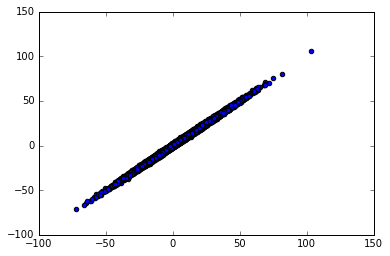

In [6]:
pdf = pd.DataFrame(train_y, columns=['actual'])
pdf['pred'] = preds
print(pdf)

plt.scatter(pdf.actual, pdf.pred)

In [7]:
mults = np.array([np.arange(10)+1, 10-np.arange(10)])

In [8]:
(np.dot(train_x, mults.T) + [5, -1]).shape

(10000, 2)

In [122]:
n = 5
lambda_ = 0 * .001
hidden = 5

train_x = np.random.normal(size=(20000, n))
val_x = np.random.normal(size=(1000, n))
test_x = np.random.normal(size=(1000, n))

train_x[:, 2] = (train_x[:, 1] + train_x[:,0]) / 2
val_x[:, 2] = (val_x[:, 1] + val_x[:,0]) / 2
test_x[:, 2] = (test_x[:, 1] + test_x[:,0]) / 2

tr_min = np.min(train_x)
tr_max = np.max(train_x)
"""
train_x -= tr_min
train_x /= (tr_max - tr_min)
val_x -= tr_min
val_x /= (tr_max - tr_min)
test_x -= tr_min
test_x /= (tr_max - tr_min)
"""

train_x = train_x.astype(np.float32)
val_x = val_x.astype(np.float32)
test_x = test_x.astype(np.float32)

"""
mults = np.array([np.arange(n) + 1, n - np.arange(n)])

train_y = (np.dot(train_x, mults.T) + [5, -1])
val_y = (np.dot(val_x, mults.T) + [5, -1])
test_y = (np.dot(test_x, mults.T) + [5, -1])

train_y += np.random.normal(size=train_y.shape)
val_y += np.random.normal(size=val_y.shape)
test_y += np.random.normal(size=test_y.shape)
"""

train_y = train_x
val_y = val_x
test_y = test_x

train_y = train_y.astype(np.float32)
val_y = val_y.astype(np.float32)
test_y = test_y.astype(np.float32)

batch_size = 75
num_labels = train_y.shape[1]

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, n))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(val_x)
    tf_test_dataset = tf.constant(test_x)
    tf_tr_dataset = tf.constant(train_x)
  
    # Variables.
    w0 = tf.Variable(tf.truncated_normal([n, hidden]))
    b0 = tf.Variable(tf.zeros([hidden]))
    w0b = tf.Variable(tf.truncated_normal([hidden, hidden]))
    b0b = tf.Variable(tf.zeros([hidden]))
    w1 = tf.Variable(tf.truncated_normal([hidden, num_labels]))
    b1 = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf_train_dataset
    logits = tf.matmul(logits, w0) + b0
    logits = tf.nn.relu(logits)
    logits = tf.nn.dropout(logits, .5)
    logits = tf.matmul(logits, w0b) + b0b
    logits = tf.nn.relu(logits)
    logits = tf.matmul(logits, w1) + b1
    
    reg = tf.nn.l2_loss(w0) + tf.nn.l2_loss(w0b) + tf.nn.l2_loss(w1)
    # loss = tf.reduce_mean(tf.nn.l2_loss(tf_train_labels - logits)) + lambda_ * reg
    loss = tf.reduce_mean(tf.square(tf_train_labels - logits)) + lambda_ * reg
  
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(5e-5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # train_prediction = tf.nn.softmax(logits)
    train_prediction = logits
    valid_prediction = tf.matmul(tf.nn.relu(
            tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w0) + b0), w0b) + b0b), w1) + b1
    test_prediction = tf.matmul(tf.nn.relu(
            tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w0) + b0), w0b) + b0b), w1) + b1
    tr_preds = tf.matmul(tf.nn.relu(
            tf.matmul(tf.nn.relu(tf.matmul(tf_tr_dataset, w0) + b0), w0b) + b0b), w1) + b1
    
num_steps = 200001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_x[offset:(offset + batch_size), :]
        batch_labels = train_y[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch RMSE: %.5f" % rmse(predictions, batch_labels))
            print("Validation RMSE: %.5f" % rmse(valid_prediction.eval(), val_y))
        
    print("Test RMSE: %.5f" % rmse(test_prediction.eval(), test_y))
    print("")
    print w0b.eval()
    print b0b.eval()
    print("")
    preds = tr_preds.eval()
    vpreds = valid_prediction.eval()

Initialized
Minibatch loss at step 0: 7.455603
Minibatch RMSE: 6.10557
Validation RMSE: 4.08336
Minibatch loss at step 1000: 4.319420
Minibatch RMSE: 4.64727
Validation RMSE: 3.46757
Minibatch loss at step 2000: 2.663568
Minibatch RMSE: 3.64936
Validation RMSE: 3.03056
Minibatch loss at step 3000: 2.490940
Minibatch RMSE: 3.52912
Validation RMSE: 2.70243
Minibatch loss at step 4000: 1.781390
Minibatch RMSE: 2.98445
Validation RMSE: 2.46438
Minibatch loss at step 5000: 2.338803
Minibatch RMSE: 3.41965
Validation RMSE: 2.29036
Minibatch loss at step 6000: 1.714833
Minibatch RMSE: 2.92817
Validation RMSE: 2.16577
Minibatch loss at step 7000: 1.362246
Minibatch RMSE: 2.60983
Validation RMSE: 2.08309
Minibatch loss at step 8000: 0.926346
Minibatch RMSE: 2.15215
Validation RMSE: 2.03112
Minibatch loss at step 9000: 1.043813
Minibatch RMSE: 2.28453
Validation RMSE: 2.00094
Minibatch loss at step 10000: 1.144049
Minibatch RMSE: 2.39170
Validation RMSE: 1.98696
Minibatch loss at step 11000: 0.9

In [123]:
train_y

array([[-2.00128508,  0.03804172, -0.98162162, -0.7840187 , -1.05235231],
       [-0.31462416,  1.13118565,  0.40828073,  1.66087878, -0.50220853],
       [-0.53382778, -0.52247697, -0.52815241, -0.36975834, -0.8841992 ],
       ..., 
       [-1.18346775, -1.30327022, -1.24336898, -0.03369075, -0.5276767 ],
       [-0.95888144,  1.06366229,  0.05239046, -1.01148772, -0.13287617],
       [-0.11556315,  1.84202516,  0.863231  , -1.95887017,  0.91337293]], dtype=float32)

In [124]:
preds

array([[-0.43807197, -0.24479866, -0.34046614, -0.24567068,  0.34705245],
       [ 0.43207794,  0.50980502,  0.47426113,  0.65837705, -0.31313023],
       [-0.1052396 , -0.21509248, -0.15854776, -0.2992509 ,  0.06210893],
       ..., 
       [-0.57955241, -0.44059539, -0.5097878 , -0.21205723,  0.27069208],
       [ 0.03865618,  0.357535  ,  0.20124346, -0.35183185,  0.54032874],
       [ 0.06441998,  0.18474722,  0.12661719, -0.38865578,  0.35615391]], dtype=float32)

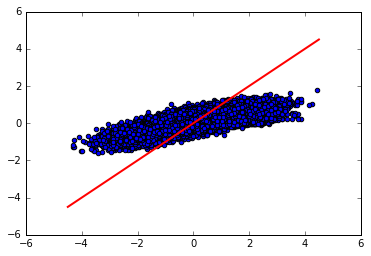

In [125]:
plt.scatter(train_y.reshape([-1,1]), preds.reshape([-1,1]))
plt.plot([-4.5, 4.5], [-4.5, 4.5], 'k-', lw=2, color='r')
plt.show()

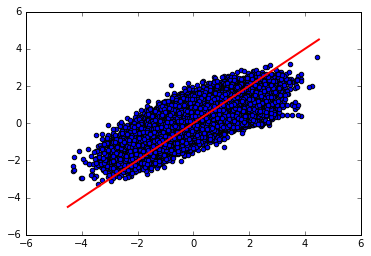

In [126]:
plt.scatter(train_y.reshape([-1,1]), 2* preds.reshape([-1,1]))
plt.plot([-4.5, 4.5], [-4.5, 4.5], 'k-', lw=2, color='r')
plt.show()

In [147]:
n = 5
lambda_ = 0 
hidden = 5

batch_size = 50

train_x = np.random.normal(size=(20000, n))
val_x = np.random.normal(size=(1000, n))
test_x = np.random.normal(size=(1000, n))

train_x = train_x.astype(np.float32)
val_x = val_x.astype(np.float32)
test_x = test_x.astype(np.float32)

mults = np.array(np.arange(n) + 1)
print mults

train_y = np.expand_dims(np.dot(train_x, mults.T) - 1, 1)
val_y = np.expand_dims(np.dot(val_x, mults.T) - 1, 1)
test_y = np.expand_dims(np.dot(test_x, mults.T) - 1, 1)

train_y += np.random.normal(size=train_y.shape)
val_y += np.random.normal(size=val_y.shape)
test_y += np.random.normal(size=test_y.shape)

train_y = train_y.astype(np.float32)
val_y = val_y.astype(np.float32)
test_y = test_y.astype(np.float32)

num_labels = train_y.shape[1]

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, n))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(val_x)
    tf_test_dataset = tf.constant(test_x)
    tf_tr_dataset = tf.constant(train_x)
  
    # Variables.
    w0 = tf.Variable(tf.truncated_normal([n, hidden]))
    b0 = tf.Variable(tf.zeros([hidden]))
    w1 = tf.Variable(tf.truncated_normal([hidden, num_labels]))
    b1 = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf_train_dataset
    logits = tf.matmul(logits, w0) + b0
    logits = tf.nn.relu(logits)
    logits = tf.nn.dropout(logits, .975)
    logits = tf.matmul(logits, w1) + b1
    
    reg = tf.nn.l2_loss(w0) + tf.nn.l2_loss(w1)
    # loss = tf.reduce_mean(tf.nn.l2_loss(tf_train_labels - logits)) + lambda_ * reg
    loss = tf.reduce_mean(tf.square(tf_train_labels - logits)) + lambda_ * reg
  
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # train_prediction = tf.nn.softmax(logits)
    train_prediction = logits
    valid_prediction = tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w0) + b0), w1) + b1
    test_prediction = tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w0) + b0), w1) + b1
    tr_preds = tf.matmul(tf.nn.relu(tf.matmul(tf_tr_dataset, w0) + b0), w1) + b1
    
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_x[offset:(offset + batch_size), :]
        batch_labels = train_y[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch RMSE: %.5f" % rmse(predictions, batch_labels))
            print("Validation RMSE: %.5f" % rmse(valid_prediction.eval(), val_y))
        
    print("Test RMSE: %.5f" % rmse(test_prediction.eval(), test_y))
    print("")
    print w0.eval()
    print b0.eval()
    print("")
    preds = tr_preds.eval()
    vpreds = valid_prediction.eval()

[1 2 3 4 5]
Initialized
Minibatch loss at step 0: 58.285282
Minibatch RMSE: 7.63448
Validation RMSE: 7.39542
Minibatch loss at step 1000: 67.411301
Minibatch RMSE: 8.21044
Validation RMSE: 7.34804
Minibatch loss at step 2000: 57.528248
Minibatch RMSE: 7.58474
Validation RMSE: 7.30120
Minibatch loss at step 3000: 46.404064
Minibatch RMSE: 6.81205
Validation RMSE: 7.25493
Minibatch loss at step 4000: 54.735336
Minibatch RMSE: 7.39833
Validation RMSE: 7.20911
Minibatch loss at step 5000: 57.887650
Minibatch RMSE: 7.60839
Validation RMSE: 7.16368
Minibatch loss at step 6000: 54.502838
Minibatch RMSE: 7.38260
Validation RMSE: 7.11843
Minibatch loss at step 7000: 59.670616
Minibatch RMSE: 7.72468
Validation RMSE: 7.07339
Minibatch loss at step 8000: 45.804893
Minibatch RMSE: 6.76793
Validation RMSE: 7.02848
Minibatch loss at step 9000: 46.996239
Minibatch RMSE: 6.85538
Validation RMSE: 6.98404
Minibatch loss at step 10000: 48.111664
Minibatch RMSE: 6.93626
Validation RMSE: 6.93949
Minibatch 

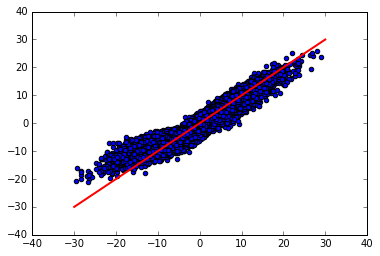

In [148]:
plt.scatter(train_y, preds)
plt.plot([-30, 30], [-30, 30], 'k-', lw=2, color='r')
plt.show()